In [116]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from skimage.feature import hog
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split

%matplotlib inline


/anaconda/envs/tensor34/lib/python3.4/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


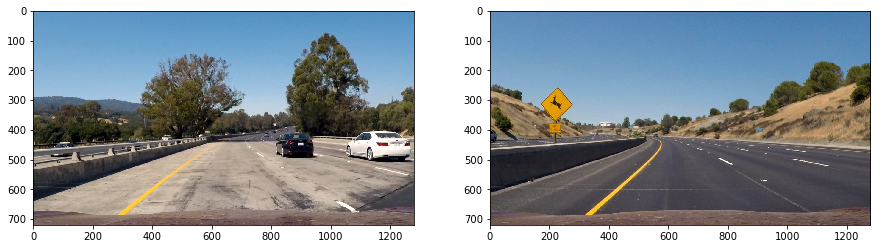

In [135]:
car_img_test = cv2.cvtColor(cv2.imread('test_images/test1.jpg'), cv2.COLOR_BGR2RGB)
notcar_img_test = cv2.cvtColor(cv2.imread('test_images/test2.jpg'), cv2.COLOR_BGR2RGB)
fig, (car, no_car) = plt.subplots(1, 2, figsize=(15,15))
car.imshow(car_img_test)
no_car.imshow(notcar_img_test)

#### Loading Traning data vehicle and non-vehicle and its exploration

In [36]:
vehicle_files = glob.glob('vehicles/**/*.png')
non_vehicles_files = glob.glob('non-vehicles/**/*.png')
print ("Count of vehicle images %d = " %len(vehicle_files))
print ("Count of non-vehicle images = %d" %len(non_vehicles_files))

Count of vehicle images 8792 = 
Count of non-vehicle images = 8968


In [37]:
def read_images_from_files(image_files):
    images = []
    for image_file in image_files:
        images.append(cv2.cvtColor(cv2.imread(image_file), cv2.COLOR_BGR2RGB))
    return images

In [38]:
vehicle_imgs = read_images_from_files(vehicle_files)
non_vehicle_imgs = read_images_from_files(non_vehicles_files)

#### Samples images of vehicle and non-vehicle in our training data

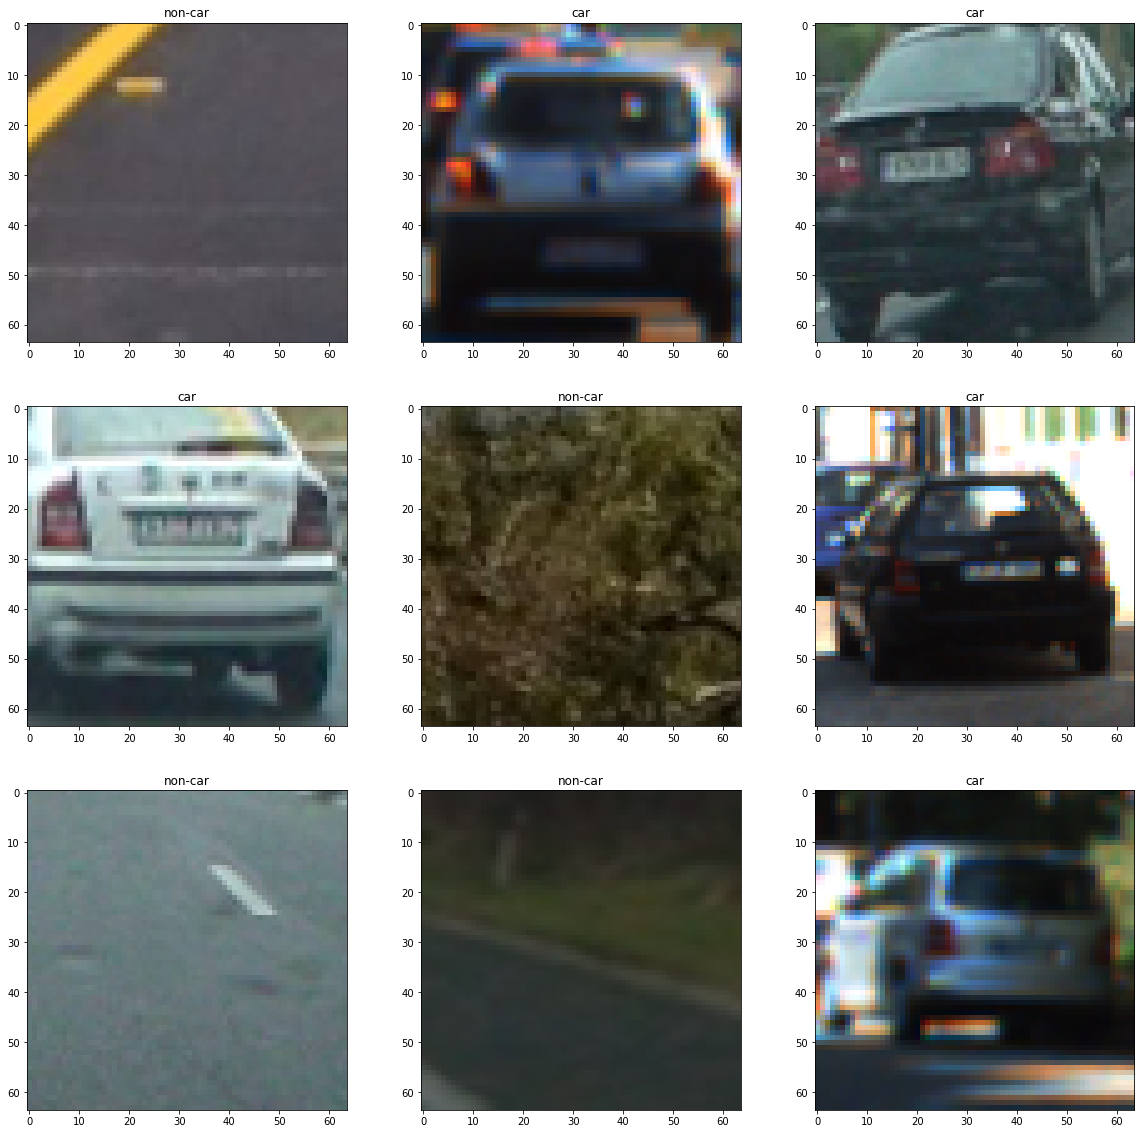

In [72]:
samp_car_imgs = []
samp_non_car_imgs = []
fig, axis = plt.subplots(3, 3, figsize=(20, 20))
for i in range(3):
    for j in range(3):
        random_num = np.random.choice(2)
        if (random_num == 0):
            #car image
            k = np.random.choice(len(vehicle_imgs))
            axis[i, j].imshow(vehicle_imgs[k])
            axis[i, j].set_title("car")
            samp_car_imgs.append(vehicle_imgs[k])
        else:
            k = np.random.choice(len(non_vehicle_imgs))
            axis[i, j].imshow(non_vehicle_imgs[k])
            axis[i, j].set_title("non-car")
            samp_non_car_imgs.append(non_vehicle_imgs[k])


In [75]:
samp_car_imgs = np.array(samp_car_imgs)
samp_non_car_imgs = np.array(samp_non_car_imgs)

#### 1. Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier

### Histogram of Oriented Gradients (HOG)

In [78]:
class HogFeatures:
    def __init__(self, orient, pixel_per_cell, cell_per_block, vis=False, feature_vec=True):
        self.orient = orient
        self.pixel_per_cell = pixel_per_cell
        self.cell_per_block = cell_per_block
        self.vis = vis
        self.feature_vec = feature_vec
    
    def get_hog_features(self, img):
        return hog(img, orientations=self.orient,\
                   pixels_per_cell=(self.pixel_per_cell, self.pixel_per_cell),\
                   cells_per_block=(self.cell_per_block, self.cell_per_block),\
                   visualise=False, feature_vector=self.feature_vec)
    
    def get_hog_features_hog_image(self, img):
        features, hog_img = hog(img, orientations=self.orient,\
                                pixels_per_cell=(self.pixel_per_cell, self.pixel_per_cell),\
                                cells_per_block=(self.cell_per_block, self.cell_per_block),\
                                visualise=True, feature_vector=False)
        return features, hog_img

In [79]:
hog_obj = HogFeatures(orient=9, pixel_per_cell=8, cell_per_block=2, vis=True)

In [93]:
samp_car_hog = []
samp_non_car_hog = []
for car_img in samp_car_imgs:
    kimg = cv2.cvtColor(car_img, cv2.COLOR_RGB2GRAY)
    _, timg = hog_obj.get_hog_features_hog_image(kimg)
    samp_car_hog.append(timg)
for non_car_img in samp_non_car_imgs:
    kimg = cv2.cvtColor(non_car_img, cv2.COLOR_RGB2GRAY)
    _, timg = hog_obj.get_hog_features_hog_image(kimg)
    samp_non_car_hog.append(timg)



/anaconda/envs/tensor34/lib/python3.4/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


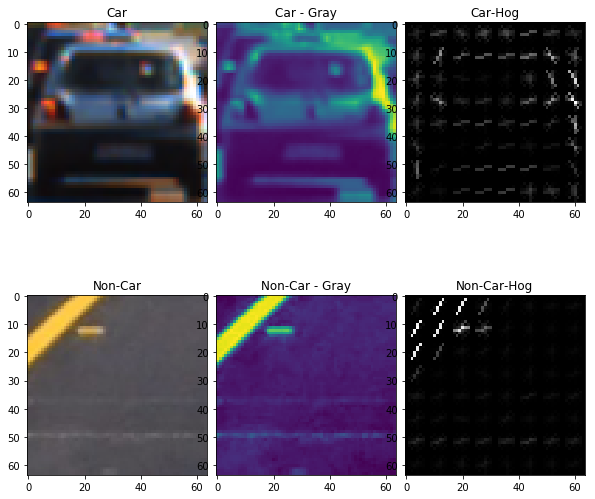

In [98]:
fig, axis = plt.subplots(2,4, figsize=(10,10))
fig.subplots_adjust(hspace = .005, wspace=0.05)
axis[0,0].imshow(samp_car_imgs[0])
axis[0,0].set_title("Car")
axis[0,1].imshow(cv2.cvtColor(samp_car_imgs[0], cv2.COLOR_RGB2GRAY))
axis[0,1].set_title("Car - Gray")
axis[0,2].imshow(samp_car_hog[0], 'gray')
axis[0,2].set_title("Car-Hog")
axis[0, 3].imshow()

axis[1,0].imshow(samp_non_car_imgs[0])
axis[1,0].set_title("Non-Car")
axis[1,1].imshow(cv2.cvtColor(samp_non_car_imgs[0], cv2.COLOR_RGB2GRAY))
axis[1,1].set_title("Non-Car - Gray")
axis[1,2].imshow(samp_non_car_hog[0], 'gray')
axis[1,2].set_title("Non-Car-Hog")

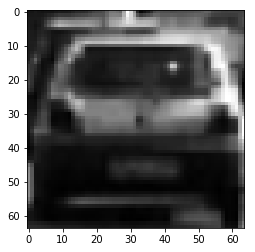

In [106]:
plt.imshow(samp_car_imgs[0][:,:,2], 'gray')

In [109]:
def extract_features(imgs, hog_obj, cspace='RGB', hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for image in imgs:
        # Read in each one by one
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(hog_obj.get_hog_features(feature_image[:,:,channel]))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = hog_obj.get_hog_features(feature_image[:,:,hog_channel])
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features


In [110]:
car_features = extract_features(vehicle_imgs, hog_obj, cspace='HLS', hog_channel=2)
non_car_features = extract_features(non_vehicle_imgs, hog_obj, cspace='HLS', hog_channel=2)

/anaconda/envs/tensor34/lib/python3.4/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [112]:
len(non_car_features)

8968

In [124]:
def Train_SVM_Classifier(car_features, notcar_features, debug_flag=False):
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    # Split up data into randomized training and test sets
    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)
    
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    train_time = round(t2-t, 2)
    # Check the score of the SVC
    accuracy = round(svc.score(X_test, y_test), 4)
    
    if debug_flag:
        print(train_time, 'Seconds to train SVC...')
        print('Test Accuracy of SVC = ', accuracy)
        # Check the prediction time for a single sample
        n_predict = 10
        print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
        print('For these',n_predict, 'labels: ', y_test[0:n_predict])
        t2 = time.time()
        print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
    return svc, accuracy, train_time

In [125]:
svm_clf, accuracy, train_time = Train_SVM_Classifier(car_features, non_car_features, debug_flag=True)

14.38 Seconds to train SVC...
Test Accuracy of SVC =  0.9023
My SVC predicts:  [ 0.  1.  0.  1.  1.  1.  0.  0.  0.  0.]
For these 10 labels:  [ 0.  1.  1.  1.  1.  1.  0.  0.  0.  0.]
14.38824 Seconds to predict 10 labels with SVC


### 2. Explain how you settled on your final choice of HOG parameters.

In [126]:
# Choosing best classifier by exploring different Hogs features.
# https://www.learnopencv.com/histogram-of-oriented-gradients/
def Parameter_selection_Accuracy(car_imgs, notcar_images):
    
    orientations_param = [8,]
    

In [ ]:
## Choosing the best classifier which gives hightest accuracy.

## Sliding Window Search

### 1. Describe how (and identify where in your code) you implemented a sliding window search. How did you decide what scales to search and how much to overlap windows?

In [3]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # make a copy of the image
    draw_img = np.copy(img)
    # draw each bounding box on your image copy using cv2.rectangle()
    for bbx in bboxes:
        cv2.rectangle(draw_img, bbx[0], bbx[1], color, thick)
    # return the image copy with boxes drawn
    return draw_img # Change this line to return image copy with boxes

In [130]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
        
    # Compute the span of the region to be searched    
    # Compute the number of pixels per step in x/y
    # Compute the number of windows in x/y
    # Initialize a list to append window positions to
    window_list = []
    
    x_step = np.int(xy_window[0]* (1- xy_overlap[0]))
    y_step = np.int(xy_window[1] * (1 - xy_overlap[1]))
    
    for x_cur in range(x_start_stop[0], x_start_stop[1] - xy_window[0] + 1, x_step):
        for y_cur in range(y_start_stop[0], y_start_stop[1] - xy_window[1] + 1, y_step):
            window_list.append(((x_cur, y_cur),(x_cur + xy_window[0], y_cur + xy_window[1])))
    return window_list


In [138]:
windows = slide_window(car_img_test, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))
                       
window_img = draw_boxes(car_img_test, windows, color=(0, 0, 255), thick=6)

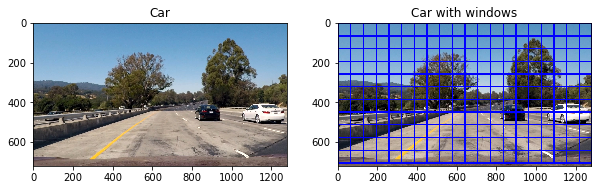

In [144]:
fig, (without_windows, with_windows) = plt.subplots(1, 2, figsize=(10,10))
without_windows.imshow(car_img_test)
without_windows.set_title("Car")
with_windows.imshow(window_img)
with_windows.set_title("Car with windows")

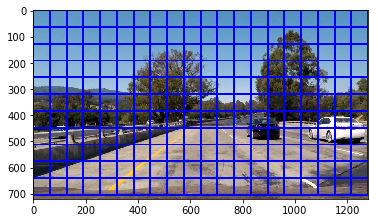

In [140]:
plt.imshow(window_img)

In [146]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features

In [147]:
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=False, hist_feat=False, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

In [148]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

#### Test an Image

In [4]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2    
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return rhist, ghist, bhist, bin_centers, hist_features

In [29]:
features, hog_image = hog_obj.get_hog_features_hog_image(car_test[:,:,0])

/anaconda/envs/tensor34/lib/python3.4/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


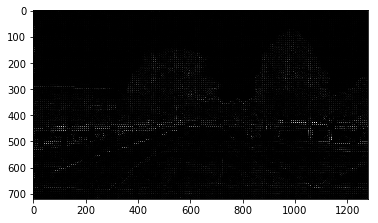

In [30]:
plt.imshow(hog_image, 'gray')

In [31]:
features = hog_obj.get_hog_features(car_test[:,:,0])

/anaconda/envs/tensor34/lib/python3.4/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [33]:
features

array([ 0.05538333,  0.12557999,  0.18664358, ...,  0.0168699 ,
        0.01238917,  0.01104597])